In [6]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image #help to work with images

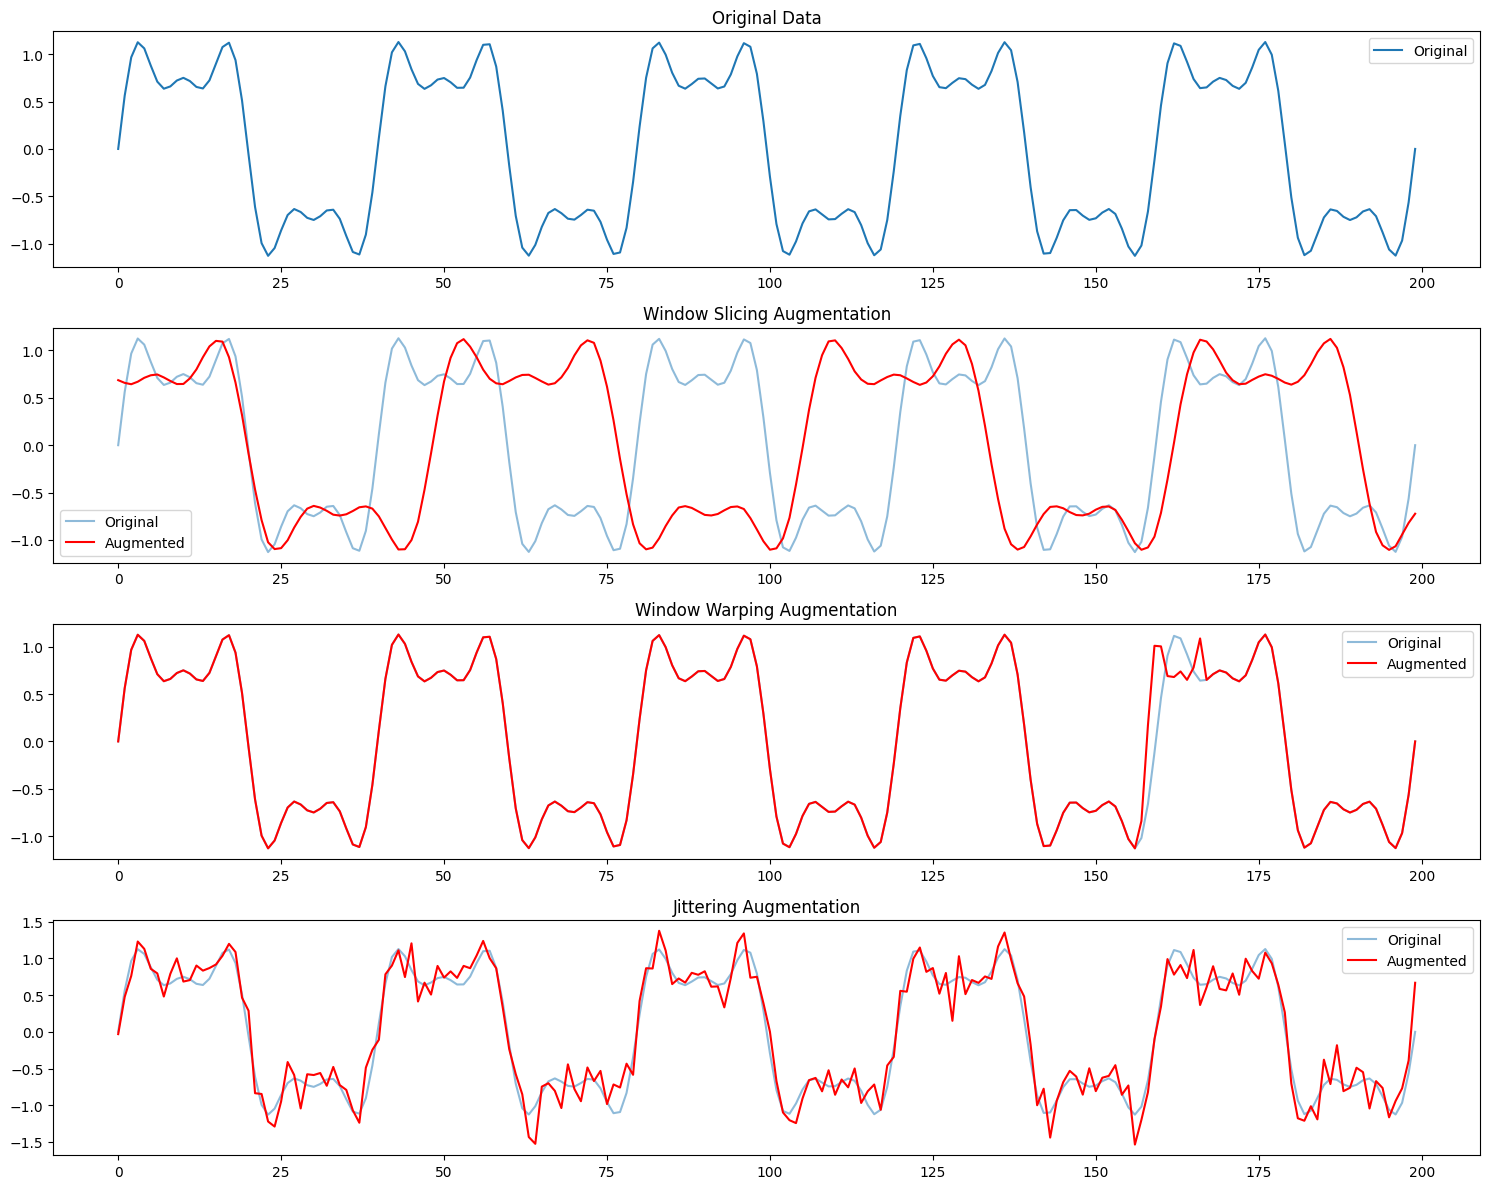

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8731157].


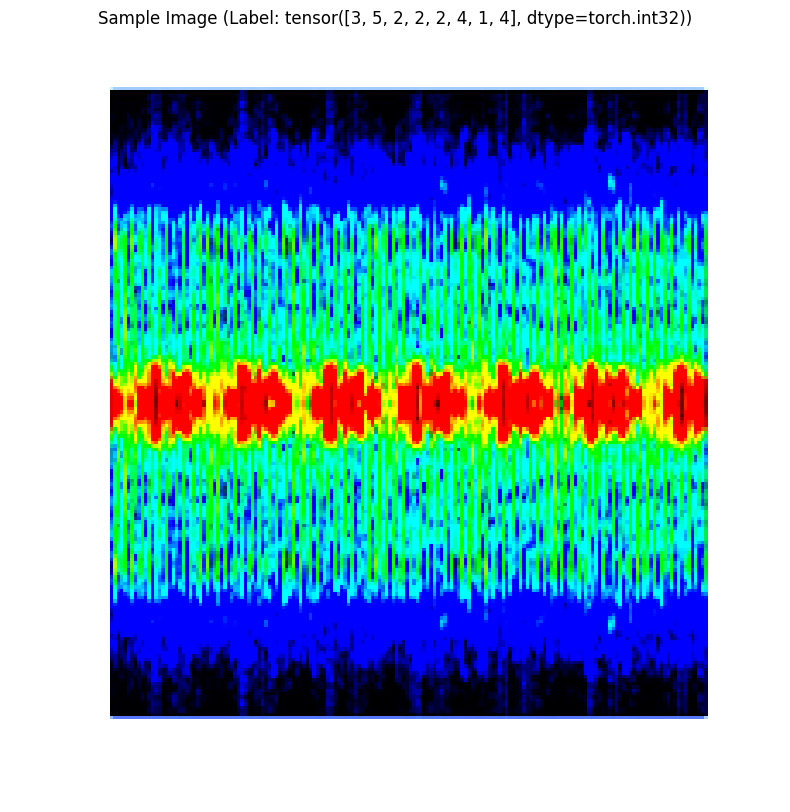

Dataset Details:
Total Images: 4849
Training Images: 4121
Validation Images: 242
Test Images: 486


In [17]:
# %% [markdown]
# # Time-Variant Data Augmentation Techniques

# %% Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# %% Time-Variant Data Augmentation Techniques
class TimeVariantDataAugmentation:
    @staticmethod
    def window_slicing(data, slice_percentage=0.9):
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        orig_width = data.shape[1]
        slice_width = int(orig_width * slice_percentage)
        max_start = orig_width - slice_width
        start_point = torch.randint(0, max_start + 1, (1,)).item()
        sliced_data = data[:, start_point:start_point + slice_width]

        augmented_data = torch.nn.functional.interpolate(
            sliced_data.unsqueeze(0), 
            size=orig_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)
        return augmented_data

    @staticmethod
    def window_warping(data, warping_factors=[0.5, 2.0]):
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        orig_width = data.shape[1]
        window_width = int(orig_width * 0.1)
        start_point = torch.randint(0, orig_width - window_width + 1, (1,)).item()
        warping_factor = np.random.choice(warping_factors)
        window = data[:, start_point:start_point + window_width]

        warped_window_width = int(window_width * warping_factor)
        warped_window = torch.nn.functional.interpolate(
            window.unsqueeze(0), 
            size=warped_window_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)

        augmented_data = data.clone()
        end_point = start_point + warped_window_width
        if warped_window_width < window_width:
            augmented_data[:, start_point:end_point] = warped_window
        else:
            augmented_data[:, start_point:start_point + window_width] = warped_window[:window_width]
        
        return augmented_data

    @staticmethod
    def jittering(data, mean=0, std_dev=0.03):
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        noise = torch.normal(mean, std_dev, size=data.shape)
        return data + noise

# %% Stochastic Augmentation Class
class StochasticAugmentation:
    def __init__(self, augmentation_methods):
        self.augmentation_methods = augmentation_methods
    
    def __call__(self, data):
        method = np.random.choice(self.augmentation_methods)
        return method(data)

# %% Custom Image Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(subfolders)
        
        # Collect image paths and labels
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(subfolder)
        
        # Encode labels
        self.labels = self.label_encoder.transform(self.labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# %% Visualization Function
def visualize_augmentation():
    t = torch.linspace(0, 10*torch.pi, 200)
    sample_data = torch.sin(t) + 0.5 * torch.sin(3*t) + 0.25 * torch.sin(5*t)
    sample_data = sample_data.unsqueeze(0)

    augmentation_methods = [
        ("Window Slicing", lambda x: TimeVariantDataAugmentation.window_slicing(x, slice_percentage=0.7)),
        ("Window Warping", lambda x: TimeVariantDataAugmentation.window_warping(x, warping_factors=[0.5])),
        ("Jittering", lambda x: TimeVariantDataAugmentation.jittering(x, mean=0, std_dev=0.2))
    ]
    
    plt.figure(figsize=(15, 12))
    plt.subplot(4, 1, 1)
    plt.title("Original Data")
    plt.plot(sample_data.numpy().flatten(), label='Original')
    plt.legend()
    
    for i, (name, aug_method) in enumerate(augmentation_methods, start=2):
        augmented_data = aug_method(sample_data)
        plt.subplot(4, 1, i)
        plt.title(f"{name} Augmentation")
        plt.plot(sample_data.numpy().flatten(), label='Original', alpha=0.5)
        plt.plot(augmented_data.numpy().flatten(), label='Augmented', color='red')
        plt.legend()

    plt.tight_layout()
    plt.show()

# %% Define dataset parameters
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    "3_long_blade_rotor",
    "3_short_blade_rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "drone", 
    "rc_plane"
]

# %% Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# %% Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

# %% Seed and shuffle
# Split dataset into train, validation, and test (without shuffling initially)
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Manually shuffle the training dataset
torch.manual_seed(42)
train_indices = torch.randperm(len(train_dataset))
train_dataset = Subset(train_dataset, train_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# %% Visualization
visualize_augmentation()

# %% Sample Visualization
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0].permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.title(f"Sample Image (Label: {sample_label})")
plt.axis('off')
plt.show()

# %% Print dataset details
print("Dataset Details:")
print(f"Total Images: {len(dataset)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(val_dataset)}")
print(f"Test Images: {len(test_dataset)}")


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)  # Reduce channels to 1
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, padding=1)  # Learn spatial weights
        self.sigmoid = nn.Sigmoid()  # Normalize attention map to [0, 1]

    def forward(self, x):
        attn = self.conv1(x)  # Reduce channel dimension
        attn = self.conv2(attn)  # Learn spatial relationships
        attn = self.sigmoid(attn)  # Normalize
        return x * attn  # Apply attention

# Define the Custom CNN with integrated Spatial Attention
class CustomCNNWithAttention(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNNWithAttention, self).__init__()
        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Attention Module
        self.attention = SpatialAttention(in_channels=128)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)  # Output for `num_classes` classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Apply Attention Mechanism
        x = self.attention(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x



In [19]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_deepercnn = CustomCNNWithAttention(num_classes=6)
model_deepercnn.to(device)

CustomCNNWithAttention(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding

In [20]:
# Loss and optimizer for Deeper CNN
criterion = nn.CrossEntropyLoss()
optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.001)
scheduler_deepercnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_deepercnn, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    model.train()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device, dtype=torch.long)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pt")
        
        model.train()

In [22]:
    # Train the model
torch.cuda.empty_cache() 
train_model(model_deepercnn, train_loader, val_loader, criterion, optimizer_deepercnn, scheduler_deepercnn, num_epochs=20)

Epoch [1/20], Loss: 0.8492, Accuracy: 0.6717
Validation Loss: 0.7848, Accuracy: 0.6983
Epoch [2/20], Loss: 0.5007, Accuracy: 0.8165
Validation Loss: 0.4964, Accuracy: 0.8182
Epoch [3/20], Loss: 0.4094, Accuracy: 0.8563
Validation Loss: 0.2806, Accuracy: 0.9050
Epoch [4/20], Loss: 0.3171, Accuracy: 0.8961
Validation Loss: 0.1852, Accuracy: 0.9463
Epoch [5/20], Loss: 0.2573, Accuracy: 0.9124
Validation Loss: 0.1828, Accuracy: 0.9545
Epoch [6/20], Loss: 0.2050, Accuracy: 0.9347
Validation Loss: 0.2884, Accuracy: 0.9050
Epoch [7/20], Loss: 0.1952, Accuracy: 0.9357
Validation Loss: 0.1646, Accuracy: 0.9669
Epoch [8/20], Loss: 0.1614, Accuracy: 0.9476
Validation Loss: 0.1421, Accuracy: 0.9545
Epoch [9/20], Loss: 0.1630, Accuracy: 0.9473
Validation Loss: 0.1166, Accuracy: 0.9669
Epoch [10/20], Loss: 0.1302, Accuracy: 0.9546
Validation Loss: 0.1715, Accuracy: 0.9545
Epoch [11/20], Loss: 0.1230, Accuracy: 0.9607
Validation Loss: 0.2023, Accuracy: 0.9463
Epoch [12/20], Loss: 0.1150, Accuracy: 0.

C:\Users\incha\AppData\Local\Temp\ipykernel_22048\305953074.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("best_model_Cust

Test Loss: 0.0582 Test Acc: 0.9774
Average Inference Time per Batch: 0.1433 seconds

Classification Report:
{'3 Long Blade Rotor': {'precision': 0.9879518072289156, 'recall': 0.9761904761904762, 'f1-score': 0.9820359281437125, 'support': 84.0}, '3 Short Blade Rotor': {'precision': 0.9655172413793104, 'recall': 0.9545454545454546, 'f1-score': 0.96, 'support': 88.0}, 'Bird': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 88.0}, 'Bird+mini-helicopter': {'precision': 0.9753086419753086, 'recall': 0.9518072289156626, 'f1-score': 0.9634146341463414, 'support': 83.0}, 'Drone': {'precision': 0.9620253164556962, 'recall': 1.0, 'f1-score': 0.9806451612903225, 'support': 76.0}, 'RC Plane': {'precision': 0.9705882352941176, 'recall': 0.9850746268656716, 'f1-score': 0.9777777777777777, 'support': 67.0}, 'accuracy': 0.977366255144033, 'macro avg': {'precision': 0.9768985403888913, 'recall': 0.9779362977528775, 'f1-score': 0.9773122502263591, 'support': 486.0}, 'weighted avg': {'precis

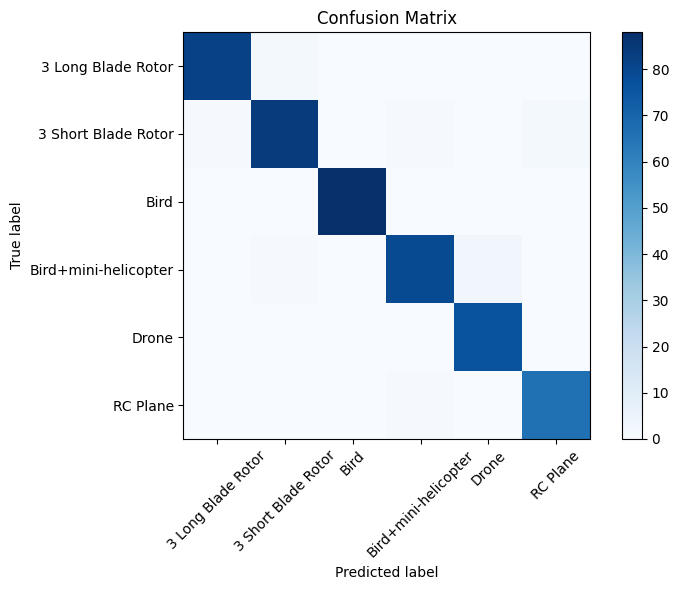

Macro Average AUC: 0.9996


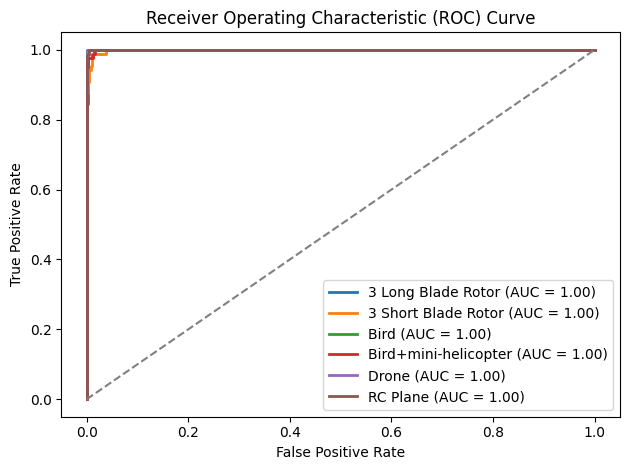

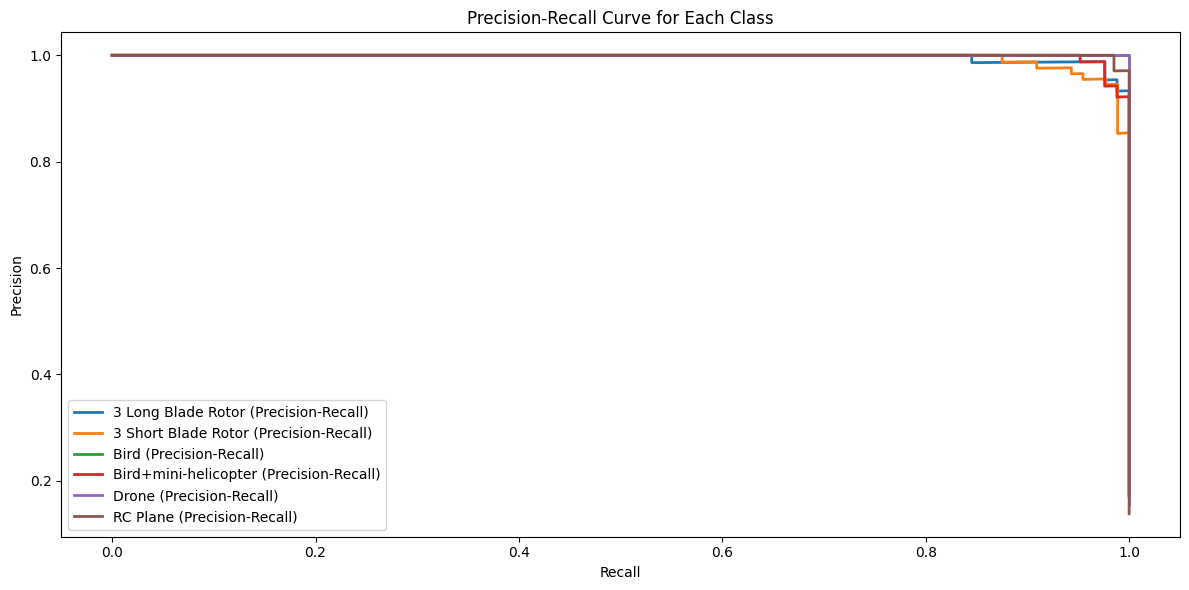

Class Distribution in Test Set: {'3 Long Blade Rotor': 84, '3 Short Blade Rotor': 88, 'Bird': 88, 'Bird+mini-helicopter': 83, 'Drone': 76, 'RC Plane': 67}
Model exported to ONNX format successfully.


In [23]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import torch.nn.functional as F
import time
import json
from sklearn.calibration import calibration_curve

# Class names for your classification task
class_names = [
    "3 Long Blade Rotor", 
    "3 Short Blade Rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "Drone", 
    "RC Plane"
]

# Test Function with Metric Collection
def test_model(model, test_loader, criterion, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    total_test = 0
    all_preds = []
    all_labels = []
    all_probs = []

    # Start time for inference benchmark
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Store metrics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_test += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

    # End time for inference benchmark
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / len(test_loader)

    # Overall metrics
    test_loss = running_loss / total_test
    test_acc = running_corrects.double() / total_test

    print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f} seconds")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(report)

    # Save Classification Report to a JSON file
    with open("classification_report.json", "w") as f:
        json.dump(report, f, indent=4)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Save confusion matrix
    np.save("confusion_matrix.npy", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # ROC Curve & AUC (for multiclass)
    all_probs = np.array(all_probs)
    if len(class_names) > 2:
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

        # Macro average AUC
        macro_auc = np.mean([auc(fpr[i], tpr[i]) for i in range(len(class_names))])
        print(f"Macro Average AUC: {macro_auc:.4f}")

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    return all_labels, all_preds, all_probs, macro_auc

# Precision-Recall Curve Plot
def plot_precision_and_recall(all_labels, all_probs, class_names):
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve((all_labels == i).astype(int), all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name} (Precision-Recall)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# Check for class distribution (Imbalanced Data Check)
def check_class_distribution(all_labels, class_names):
    unique, counts = np.unique(all_labels, return_counts=True)
    class_distribution = dict(zip(class_names, counts))
    print("Class Distribution in Test Set:", class_distribution)

# Example Usage
if __name__ == "__main__":
    # Initialize Model and Data
    model_deepercnn = CustomCNNWithAttention(num_classes=len(class_names))
    model_deepercnn.load_state_dict(torch.load("best_model_CustomCNNWithAttention.pt"))
    criterion = nn.CrossEntropyLoss()

    # Test Model
    all_labels, all_preds, all_probs, macro_auc = test_model(model_deepercnn, test_loader, criterion)

    # Plot Precision-Recall Curves
    plot_precision_and_recall(all_labels, all_probs, class_names)

    # Check for Class Imbalance
    check_class_distribution(all_labels, class_names)

    # Prepare for ONNX Conversion (Optional)
    dummy_input = torch.randn(1, 3, 224, 224, device="cuda" if torch.cuda.is_available() else "cpu")  # Adjust for your input size
    torch.onnx.export(model_deepercnn, dummy_input, "cnnwithattention.onnx", input_names=['input'], output_names=['output'])

    print("Model exported to ONNX format successfully.")

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tqdm import tqdm

# Model Definition: CustomCNNWithLSTM
class CustomCNNWithLSTM(nn.Module):
    def __init__(self, num_classes=6, lstm_hidden_size=128, lstm_num_layers=2):
        super(CustomCNNWithLSTM, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout_cnn = nn.Dropout(0.3)

        # LSTM
        self.lstm_input_size = 128
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc1 = nn.Linear(lstm_hidden_size * 2, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_cnn(x)

        # Flatten for LSTM input
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)

        # LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.to(device)
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Training Phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        # Use tqdm for training progress bar
        for inputs, labels in tqdm(train_loader, desc="Training", ncols=100, dynamic_ncols=True):
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        epoch_loss = train_loss / len(train_loader.dataset)
        epoch_acc = train_corrects.double() / len(train_loader.dataset)

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        # Use tqdm for validation progress bar
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", ncols=100, dynamic_ncols=True):
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Save the best model
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved as best_model.pth")

    print("Training complete.")
    print(f"Best Validation Loss: {best_loss:.4f}")


# Example Usage
if __name__ == "__main__":
    # Define the DataLoader instances (train_loader and val_loader) with your data

    num_classes = 6
    model_cnn_lstm = CustomCNNWithLSTM(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_cnn_lstm.parameters(), lr=0.0001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Train the model (replace train_loader and val_loader with your actual data loaders)
    train_model(
        model_cnn_lstm,
        train_loader,  # Your DataLoader for training data
        val_loader,    # Your DataLoader for validation data
        criterion,
        optimizer,
        scheduler,
        num_epochs=15,
        device=device
    )


Epoch 1/15
----------


Training: 100%|██████████| 516/516 [01:41<00:00,  5.10it/s]


Training Loss: 1.5232 Acc: 0.3421


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]


Validation Loss: 1.2270 Acc: 0.4835
Model saved as best_model.pth
Epoch 2/15
----------


Training: 100%|██████████| 516/516 [01:31<00:00,  5.67it/s]


Training Loss: 1.0247 Acc: 0.5773


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]


Validation Loss: 0.8443 Acc: 0.6736
Model saved as best_model.pth
Epoch 3/15
----------


Training: 100%|██████████| 516/516 [01:31<00:00,  5.63it/s]


Training Loss: 0.8996 Acc: 0.6282


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.84it/s]


Validation Loss: 1.0284 Acc: 0.5702
Epoch 4/15
----------


Training: 100%|██████████| 516/516 [01:32<00:00,  5.58it/s]


Training Loss: 0.6967 Acc: 0.7156


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.09it/s]


Validation Loss: 2.3352 Acc: 0.3471
Epoch 5/15
----------


Training: 100%|██████████| 516/516 [01:28<00:00,  5.85it/s]


Training Loss: 0.6063 Acc: 0.7586


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.13it/s]


Validation Loss: 0.5075 Acc: 0.8017
Model saved as best_model.pth
Epoch 6/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.75it/s]


Training Loss: 0.5122 Acc: 0.8015


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]


Validation Loss: 0.4112 Acc: 0.8471
Model saved as best_model.pth
Epoch 7/15
----------


Training: 100%|██████████| 516/516 [01:30<00:00,  5.70it/s]


Training Loss: 0.4494 Acc: 0.8287


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.10it/s]


Validation Loss: 0.3845 Acc: 0.8843
Model saved as best_model.pth
Epoch 8/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.77it/s]


Training Loss: 0.3208 Acc: 0.8898


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.16it/s]


Validation Loss: 0.2946 Acc: 0.9008
Model saved as best_model.pth
Epoch 9/15
----------


Training: 100%|██████████| 516/516 [01:28<00:00,  5.81it/s]


Training Loss: 0.3068 Acc: 0.8925


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.09it/s]


Validation Loss: 0.2577 Acc: 0.9215
Model saved as best_model.pth
Epoch 10/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.77it/s]


Training Loss: 0.2721 Acc: 0.9107


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.08it/s]


Validation Loss: 0.2444 Acc: 0.9256
Model saved as best_model.pth
Epoch 11/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.77it/s]


Training Loss: 0.2590 Acc: 0.9107


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.48it/s]


Validation Loss: 0.2343 Acc: 0.9215
Model saved as best_model.pth
Epoch 12/15
----------


Training: 100%|██████████| 516/516 [01:23<00:00,  6.16it/s]


Training Loss: 0.2414 Acc: 0.9211


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]


Validation Loss: 0.2224 Acc: 0.9298
Model saved as best_model.pth
Epoch 13/15
----------


Training: 100%|██████████| 516/516 [01:22<00:00,  6.23it/s]


Training Loss: 0.2316 Acc: 0.9219


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.29it/s]


Validation Loss: 0.1899 Acc: 0.9463
Model saved as best_model.pth
Epoch 14/15
----------


Training: 100%|██████████| 516/516 [01:18<00:00,  6.58it/s]


Training Loss: 0.2248 Acc: 0.9250


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.55it/s]


Validation Loss: 0.1698 Acc: 0.9504
Model saved as best_model.pth
Epoch 15/15
----------


Training: 100%|██████████| 516/516 [01:20<00:00,  6.37it/s]


Training Loss: 0.2041 Acc: 0.9357


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.12it/s]

Validation Loss: 0.1834 Acc: 0.9545
Training complete.
Best Validation Loss: 0.1698


C:\Users\incha\AppData\Local\Temp\ipykernel_26428\1704837883.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("best_model.pth

Test Loss: 0.2539 Test Acc: 0.9198
Average Inference Time per Batch: 0.1878 seconds

Classification Report:
{'3 Long Blade Rotor': {'precision': 0.9102564102564102, 'recall': 0.8452380952380952, 'f1-score': 0.8765432098765432, 'support': 84.0}, '3 Short Blade Rotor': {'precision': 0.7802197802197802, 'recall': 0.8875, 'f1-score': 0.8304093567251462, 'support': 80.0}, 'Bird': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 80.0}, 'Bird+mini-helicopter': {'precision': 0.9746835443037974, 'recall': 0.9166666666666666, 'f1-score': 0.9447852760736196, 'support': 84.0}, 'Drone': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 78.0}, 'RC Plane': {'precision': 0.875, 'recall': 0.875, 'f1-score': 0.875, 'support': 80.0}, 'accuracy': 0.9197530864197531, 'macro avg': {'precision': 0.9233599557966646, 'recall': 0.920734126984127, 'f1-score': 0.9211229737792181, 'support': 486.0}, 'weighted avg': {'precision': 0.9233591329231273, 'recall': 0.9197530864197531, 'f1-score':

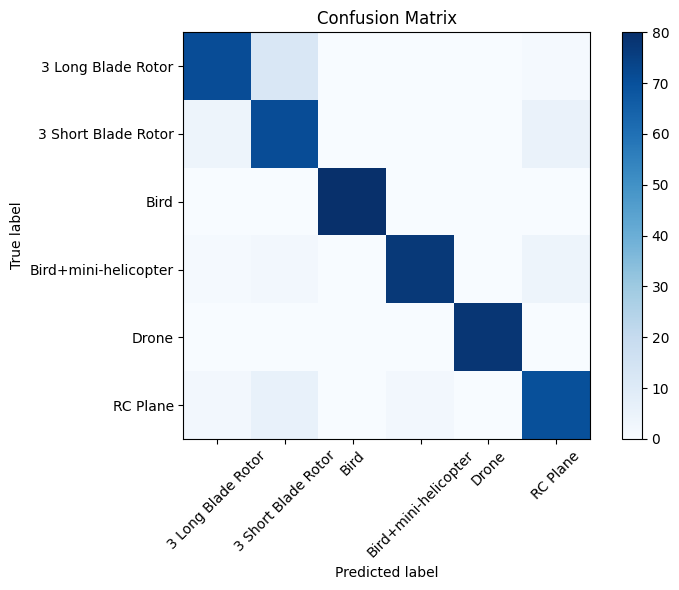

Macro Average AUC: 0.9889


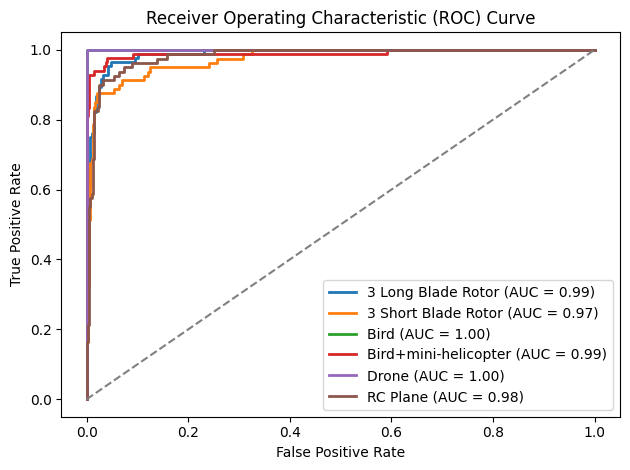

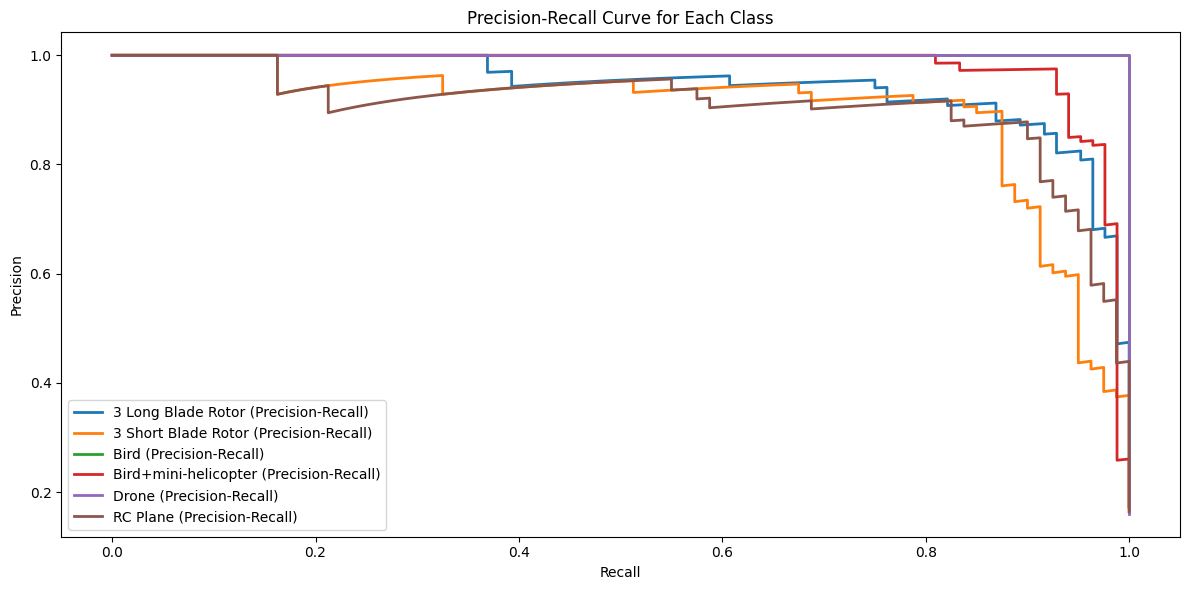

Class Distribution in Test Set: {'3 Long Blade Rotor': 84, '3 Short Blade Rotor': 80, 'Bird': 80, 'Bird+mini-helicopter': 84, 'Drone': 78, 'RC Plane': 80}


c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\onnx\symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Model exported to ONNX format successfully.


In [34]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import torch.nn.functional as F
import time
import json
from sklearn.calibration import calibration_curve

# Class names for your classification task
class_names = [
    "3 Long Blade Rotor", 
    "3 Short Blade Rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "Drone", 
    "RC Plane"
]

# Test Function with Metric Collection
def test_model(model, test_loader, criterion, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    total_test = 0
    all_preds = []
    all_labels = []
    all_probs = []

    # Start time for inference benchmark
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Store metrics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_test += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

    # End time for inference benchmark
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / len(test_loader)

    # Overall metrics
    test_loss = running_loss / total_test
    test_acc = running_corrects.double() / total_test

    print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f} seconds")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(report)

    # Save Classification Report to a JSON file
    with open("classification_report.json", "w") as f:
        json.dump(report, f, indent=4)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Save confusion matrix
    np.save("confusion_matrix.npy", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # ROC Curve & AUC (for multiclass)
    all_probs = np.array(all_probs)
    if len(class_names) > 2:
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

        # Macro average AUC
        macro_auc = np.mean([auc(fpr[i], tpr[i]) for i in range(len(class_names))])
        print(f"Macro Average AUC: {macro_auc:.4f}")

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    return all_labels, all_preds, all_probs, macro_auc

# Precision-Recall Curve Plot
def plot_precision_and_recall(all_labels, all_probs, class_names):
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve((all_labels == i).astype(int), all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name} (Precision-Recall)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# Check for class distribution (Imbalanced Data Check)
def check_class_distribution(all_labels, class_names):
    unique, counts = np.unique(all_labels, return_counts=True)
    class_distribution = dict(zip(class_names, counts))
    print("Class Distribution in Test Set:", class_distribution)

# Example Usage
if __name__ == "__main__":
    # Initialize Model and Data
    model_deepercnn = CustomCNNWithLSTM(num_classes=len(class_names))
    model_deepercnn.load_state_dict(torch.load("best_model.pth"))
    criterion = nn.CrossEntropyLoss()

    # Test Model
    all_labels, all_preds, all_probs, macro_auc = test_model(model_deepercnn, test_loader, criterion)

    # Plot Precision-Recall Curves
    plot_precision_and_recall(all_labels, all_probs, class_names)

    # Check for Class Imbalance
    check_class_distribution(all_labels, class_names)

    # Prepare for ONNX Conversion (Optional)
    dummy_input = torch.randn(1, 3, 224, 224, device="cuda" if torch.cuda.is_available() else "cpu")  # Adjust for your input size
    torch.onnx.export(model_deepercnn, dummy_input, "model.onnx", input_names=['input'], output_names=['output'])

    print("Model exported to ONNX format successfully.")

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

def test_model(model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type torch.long

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Generate Classification Report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, digits=4))

    # Generate Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(all_targets, all_preds))

# Example Usage
# Assuming test_loader is defined
if __name__ == "__main__":
    # Load the trained model weights
    model_deepercnn = CustomCNNWithAttention(num_classes=6)
    model_deepercnn.load_state_dict(torch.load("customcnnwithAttention.pth"))

    # Evaluate the model on test data
    test_model(model_deepercnn, test_loader)


C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_22584\66978296.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("customcn

Classification Report:
              precision    recall  f1-score   support

           0     0.9630    0.9286    0.9455        84
           1     0.9059    0.9625    0.9333        80
           2     1.0000    1.0000    1.0000        80
           3     1.0000    0.9762    0.9880        84
           4     1.0000    1.0000    1.0000        78
           5     0.9750    0.9750    0.9750        80

    accuracy                         0.9733       486
   macro avg     0.9740    0.9737    0.9736       486
weighted avg     0.9740    0.9733    0.9734       486

Confusion Matrix:
[[78  6  0  0  0  0]
 [ 3 77  0  0  0  0]
 [ 0  0 80  0  0  0]
 [ 0  0  0 82  0  2]
 [ 0  0  0  0 78  0]
 [ 0  2  0  0  0 78]]


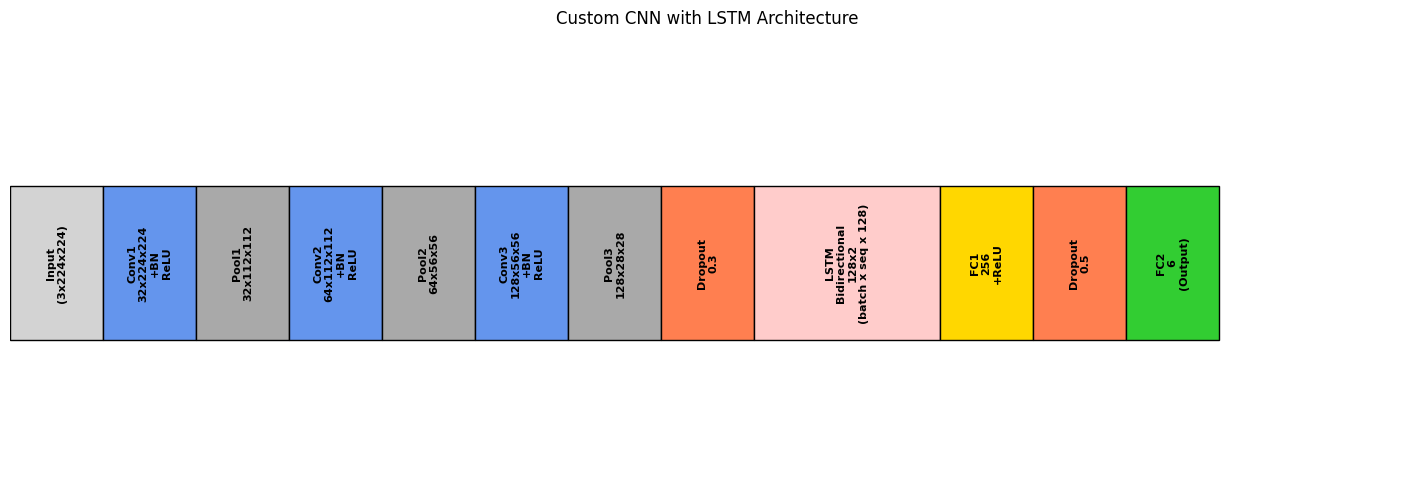

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define colors for different types of layers
colors = {
    'input': '#d3d3d3',  # Light gray for Input Layer
    'conv': '#6495ed',   # Blue for Convolution + BatchNorm + ReLU
    'pool': '#a9a9a9',   # Dark gray for Max Pooling
    'dropout': '#ff7f50',  # Coral for Dropout
    'lstm': '#ffcccb',   # Light Red for LSTM
    'dense': '#ffd700',  # Gold for Fully Connected + Dropout
    'output': '#32cd32'  # Lime for Output
}

def draw_block(ax, x, y, width, height, label, color):
    """Helper function to draw a rectangular block with text."""
    rect = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, label, color='black',
            ha='center', va='center', fontsize=8, weight="bold", rotation=90)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(18, 6))

# Block dimensions
block_width = 0.5

# Draw the Input Layer
draw_block(ax, 0, 1, block_width, 1, 'Input\n(3x224x224)', colors['input'])

# Convolutional and Pooling Layers
layers = [
    ('Conv1\n32x224x224\n+BN\nReLU', colors['conv']),
    ('Pool1\n32x112x112', colors['pool']),
    ('Conv2\n64x112x112\n+BN\nReLU', colors['conv']),
    ('Pool2\n64x56x56', colors['pool']),
    ('Conv3\n128x56x56\n+BN\nReLU', colors['conv']),
    ('Pool3\n128x28x28', colors['pool']),
    ('Dropout\n0.3', colors['dropout']),
]

x_offset = block_width
for layer, color in layers:
    draw_block(ax, x_offset, 1, block_width, 1, layer, color)
    x_offset += block_width

# LSTM Layer
draw_block(ax, x_offset, 1, block_width * 2, 1, 'LSTM\nBidirectional\n128x2\n(batch x seq x 128)', colors['lstm'])
x_offset += block_width * 2

# Fully Connected Layers
fc_layers = [
    ('FC1\n256\n+ReLU', colors['dense']),
    ('Dropout\n0.5', colors['dropout']),
    ('FC2\n6\n(Output)', colors['output'])
]

for layer, color in fc_layers:
    draw_block(ax, x_offset, 1, block_width, 1, layer, color)
    x_offset += block_width

# Configure plot
ax.set_xlim(0, x_offset + 1)
ax.set_ylim(0, 3)
ax.axis('off')

# Title
plt.title('Custom CNN with LSTM Architecture')
plt.show()


In [25]:
# %% Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

# %% Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

# %% CNN with LSTM and Attention
class CustomCNNWithLSTM(nn.Module):
    def __init__(self, num_classes=6, lstm_hidden_size=256, lstm_num_layers=2):
        super(CustomCNNWithLSTM, self).__init__()
        # CNN Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # LSTM Layers
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Attention Layer
        self.attention = Attention(lstm_hidden_size)

        # Fully Connected Layers
        self.fc1 = nn.Linear(lstm_hidden_size * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Flatten for LSTM
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)

        # LSTM + Attention
        lstm_out, _ = self.lstm(x)
        x = self.attention(lstm_out)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# %% Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None, label_encoder=None):
        self.image_paths = []
        self.labels = []
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(folder_path, img_name))
                    self.labels.append(subfolder)
        if label_encoder:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.labels)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# %% Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# %% Dataset Preparation
base_dir = "DIAT-uSAT_dataset"
subfolders = ["3_long_blade_rotor", "3_short_blade_rotor", "Bird", "Bird+mini-helicopter", "drone", "rc_plane"]

label_encoder = LabelEncoder()
label_encoder.fit(subfolders)

train_dataset = CustomImageDataset(base_dir, subfolders, transform, label_encoder)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# %% Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# %% Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNNWithLSTM(num_classes=len(subfolders)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# %% Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()  # Ensure labels are of type long

            outputs = model(images)

            # Ensure outputs and labels have correct shapes
            assert outputs.shape[1] == len(subfolders), "Output classes don't match the number of labels"

            loss = criterion(outputs, labels)  # Labels should be of type long

            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Get predicted class labels
            train_labels.extend(labels.cpu().numpy())  # Get true class labels

        train_acc = accuracy_score(train_labels, train_preds)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Acc: {val_acc:.4f}")

# %% Train Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

torch.save(model.state_dict(), "custom_cnn_lstm_model.pth")
print("Model saved!")


Epoch 1/20, Train Loss: 0.9637, Train Acc: 0.6081
Validation Loss: 1.6030, Validation Acc: 0.4990
Epoch 2/20, Train Loss: 0.6486, Train Acc: 0.7564
Validation Loss: 0.4759, Validation Acc: 0.8289
Epoch 3/20, Train Loss: 0.4112, Train Acc: 0.8551
Validation Loss: 0.3839, Validation Acc: 0.8732
Epoch 4/20, Train Loss: 0.3462, Train Acc: 0.8814
Validation Loss: 0.9806, Validation Acc: 0.7155
Epoch 5/20, Train Loss: 0.3261, Train Acc: 0.8866
Validation Loss: 0.5992, Validation Acc: 0.8216
Epoch 6/20, Train Loss: 0.2721, Train Acc: 0.9033
Validation Loss: 0.2847, Validation Acc: 0.9113
Epoch 7/20, Train Loss: 0.2255, Train Acc: 0.9268
Validation Loss: 0.2577, Validation Acc: 0.9186
Epoch 8/20, Train Loss: 0.2269, Train Acc: 0.9301
Validation Loss: 0.1997, Validation Acc: 0.9423
Epoch 9/20, Train Loss: 0.1701, Train Acc: 0.9469
Validation Loss: 0.2421, Validation Acc: 0.9258
Epoch 10/20, Train Loss: 0.1698, Train Acc: 0.9461
Validation Loss: 0.2228, Validation Acc: 0.9381
Epoch 11/20, Train 

In [2]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision import transforms
import time

# Load the ONNX model
model_path = "cnnwithattention.onnx"
session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Get input and output information
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
input_shape = session.get_inputs()[0].shape

# Print input shape to understand the expected input dimensions
print(f"Expected input shape: {input_shape}")

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the six classes
classes = ["3 Long Blade Rotor", "3 Short Blade Rotor", "Bird", "Bird+mini-helicopter", "Drone", "RC Plane"]

# Load an image (replace with the path to your image)
image_path = "D:/Micro-Classify/ml_model/notebooks/DIAT-uSAT_dataset/3_long_blade_rotor/figure1.jpg"
image = Image.open(image_path)

# Apply the transformations
input_tensor = transform(image)

# Add a batch dimension (since ONNX model expects a batch of images)
input_tensor = input_tensor.unsqueeze(0)  # Shape becomes (1, 3, 224, 224)

# Convert the tensor to a numpy array
input_array = input_tensor.numpy()

# Start timer for inference
start_time = time.time()

# Run the inference
output = session.run([output_name], {input_name: input_array})

# End timer for inference
end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time

# Process the output
output_probabilities = np.squeeze(output[0])  # Remove unnecessary dimensions
predicted_class = np.argmax(output_probabilities)  # Get index of the highest probability

# Display results
print(f"Predicted Class: {classes[predicted_class]}")
print(f"Probability: {output_probabilities[predicted_class]:.4f}")
print(f"Inference Time: {inference_time:.4f} seconds")

Expected input shape: [1, 3, 224, 224]
Predicted Class: 3 Long Blade Rotor
Probability: 2.3634
Inference Time: 0.0090 seconds


In [3]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision import transforms
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the ONNX model
model_path = "cnnwithattention.onnx"
session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Get input and output information
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the six classes
classes = ["3_long_blade_rotor", "3_short_blade_rotor", "Bird", "Bird+mini-helicopter", "drone", "rc_plane"]

def preprocess_image(image_path):
    """
    Preprocess an image for model inference
    """
    image = Image.open(image_path)
    input_tensor = transform(image)
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor.numpy().astype(np.float32)

def predict_image(session, input_array, input_name, output_name):
    """
    Run inference on a single image
    """
    output = session.run([output_name], {input_name: input_array})
    output_probabilities = np.squeeze(output[0])
    return np.argmax(output_probabilities)

def evaluate_model(dataset_root):
    """
    Evaluate the ONNX model and generate classification report
    
    :param dataset_root: Root directory containing subdirectories for each class
    :return: Tuple of (true labels, predicted labels)
    """
    true_labels = []
    predicted_labels = []
    
    # Iterate through each class directory
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_root, class_name)
        
        # Check if directory exists
        if not os.path.isdir(class_path):
            print(f"Warning: Directory {class_path} does not exist.")
            continue
        
        # Process each image in the class directory
        for image_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, image_filename)
            
            try:
                # Preprocess the image
                input_array = preprocess_image(image_path)
                
                # Predict the class
                predicted_class = predict_image(session, input_array, input_name, output_name)
                
                # Store true and predicted labels
                true_labels.append(class_idx)
                predicted_labels.append(predicted_class)
            
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    return true_labels, predicted_labels

def generate_classification_report(dataset_root):
    """
    Generate and print classification report
    
    :param dataset_root: Root directory containing subdirectories for each class
    """
    # Evaluate the model
    true_labels, predicted_labels = evaluate_model(dataset_root)
    
    # Generate classification report
    report = classification_report(
        true_labels, 
        predicted_labels, 
        target_names=classes, 
        digits=4
    )
    print("Classification Report:")
    print(report)
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10,8))
    
    # Create confusion matrix with Matplotlib
    im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar(im)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)
    plt.savefig('confusion_matrix.png')
    plt.close()

# Usage
# Replace with the path to your test dataset root directory
dataset_root = "D:/Micro-Classify/ml_model/notebooks/DIAT-uSAT_dataset"
generate_classification_report(dataset_root)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor     0.9949    0.9800    0.9874       799
 3_short_blade_rotor     0.9803    0.9938    0.9870       800
                Bird     1.0000    1.0000    1.0000       800
Bird+mini-helicopter     0.9843    0.9988    0.9915       815
               drone     1.0000    1.0000    1.0000       835
            rc_plane     0.9975    0.9838    0.9906       800

            accuracy                         0.9928      4849
           macro avg     0.9928    0.9927    0.9927      4849
        weighted avg     0.9928    0.9928    0.9928      4849

